In [1]:
%matplotlib ipympl
import cv2 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

class RectInput:
    def __init__(self, image):
        self.fig, self.ax = plt.subplots()
        self.pev = None
        self.rect = None
        self.ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_move)
        self.bbox = None
        plt.show()
        
    def on_press(self, ev):
        self.pev = ev
        if self.rect is None:
            self.rect = patches.Rectangle((ev.xdata, ev.ydata), 1, 1, color='white', fill=False)
            self.ax.add_patch(self.rect)
        else:
            self.rect.set_bounds(ev.xdata, ev.ydata, 1, 1)

    def on_release(self, ev):
        self.pev = None
    
    def on_move(self, ev):
        if self.pev is None: return
        self.bbox = (int(min(self.pev.xdata, ev.xdata)),
                     int(min(self.pev.ydata, ev.ydata)),
                     int(abs(self.pev.xdata - ev.xdata)),
                     int(abs(self.pev.ydata - ev.ydata)))
        self.ax.set_xlabel('bbox {} {} {} {}'.format(*self.bbox))
        self.rect.set_bounds(*self.bbox) 
        self.fig.canvas.draw()


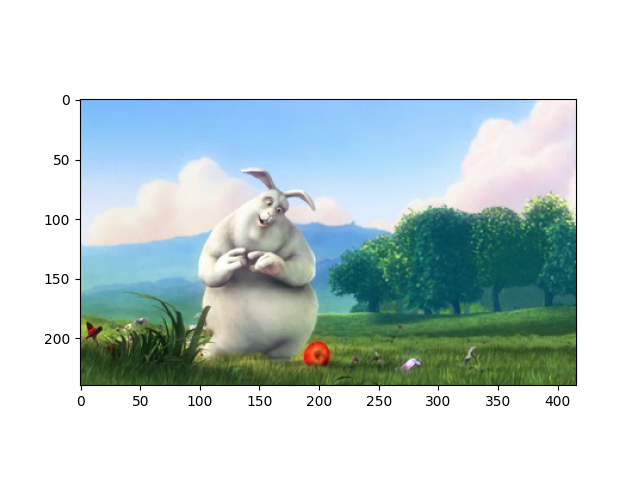

In [4]:
%run ipython_show_image.ipynb
cap = cv2.VideoCapture('bbb.mp4') 
scaling_factor = 1.0
first_frame = get_frame(cap, scaling_factor)
cap.release()

rinput = RectInput(first_frame)

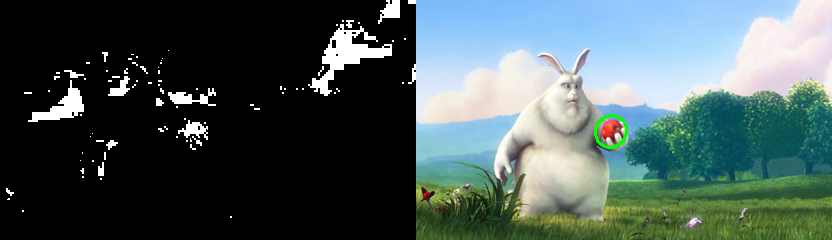

In [5]:
x,y,w,h = rinput.bbox
hsv = cv2.cvtColor(first_frame, cv2.COLOR_BGR2HSV)
hsv_roi = hsv[y:y+h, x:x+w]
hist = cv2.calcHist([hsv_roi], [0], None, [16], [0,180])
cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)

track_window = (x,y,w,h)

cap = cv2.VideoCapture('bbb.mp4') 
try:
    while True:
        frame = get_frame(cap, scaling_factor)
        if frame is None: break
            
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        hsv_backproj = cv2.calcBackProject([hsv], [0], hist, [0,180], 1)
        track_box, track_window = cv2.CamShift(hsv_backproj, track_window,
                        (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)) 
        
        bp = cv2.cvtColor(hsv_backproj, cv2.COLOR_GRAY2BGR)
        cv2.ellipse(frame, track_box, (0,255,0), 2)
        img2 = cv2.hconcat([bp, frame])
        show_image(img2)
        time.sleep(0.03)
        
except KeyboardInterrupt:
    print('Interrupted')

cap.release()